In [1]:
!git clone https://github.com/TAUTOLOGY-EDUCATION/DATASET.git

Cloning into 'DATASET'...
remote: Enumerating objects: 561, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 561 (delta 5), reused 100 (delta 4), pack-reused 459
Receiving objects: 100% (561/561), 1.93 GiB | 43.31 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (540/540), done.


In [2]:
!pip install timm

     |████████████████████████████████| 431 kB 24.5 MB/s 


In [33]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import albumentations
import albumentations.pytorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import timm
from tqdm import tqdm

In [34]:
random_state=32
sns.set_theme(color_codes=True)

# Configuration

In [27]:
class config:

    data_dir = './DATASET/HorapaVsKaprao'

    classes = ['horapa', 'kaprao']
    num_classes = len(classes)

    mean_imagenet = (0.485, 0.456, 0.406)
    std_imagenet  = (0.229, 0.224, 0.225)

    model_name = 'tf_efficientnetv2_s'

    if model_name == 'tf_efficientnetv2_s':
        image_size = 300
    elif model_name in ['tf_efficientnetv2_m', 'tf_efficientnetv2_l']:
        # image_size = 384
        image_size = 224
    elif model_name == 'tf_efficientnetv2_b3':
        image_size = 240
    elif model_name in ['convnext_large_in22k', 'convnext_xlarge_in22k']:
        image_size = 224
    elif model_name == 'vit_base_patch16_224':
        image_size = 224

    batch_size = 16

    lr = 0.00005
    gamma = 0.97

# Dataset

In [28]:
class HorapaKapraoDataset(Dataset):

    def __init__(self, image_paths, labels, image_size=224, dataset='train', transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.image_size = image_size
        self.dataset = dataset

        if transform == None:
            self.transform = self.get_transform()
        else:
            self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = self.load_image(image_path=image_path)
        image = self.transform(image=image)['image']
        label = self.labels[index]
        return image, label

    def load_image(self, image_path):
        image = np.array(Image.open(image_path).convert('RGB'))
        return image
    
    def get_transform(self):
        if self.dataset == 'train':
            transform = albumentations.Compose([
                albumentations.OneOf([
                    albumentations.HorizontalFlip(p=1),
                    albumentations.VerticalFlip(p=1),
                    albumentations.Rotate(limit=360, p=1),                  
                ], p=0.5),
                albumentations.RandomCrop(height=self.image_size, width=self.image_size, p=0.5),
                albumentations.ShiftScaleRotate(border_mode=cv2.BORDER_CONSTANT, scale_limit=0.3,
                                                rotate_limit=(10, 30), p=0.5),
                albumentations.MotionBlur(p=0.5),
                albumentations.OpticalDistortion(p=0.5),
                albumentations.GaussNoise(p=0.5),
                albumentations.Resize(width=self.image_size, height=self.image_size,
                                      interpolation=cv2.INTER_CUBIC),
                albumentations.Normalize(mean=config.mean_imagenet, std=config.std_imagenet),
                albumentations.pytorch.ToTensor(),             
            ])
        else:
            transform = albumentations.Compose([
                albumentations.Resize(width=self.image_size, height=self.image_size,
                                      interpolation=cv2.INTER_CUBIC),
                albumentations.Normalize(mean=config.mean_imagenet, std=config.std_imagenet),
                albumentations.pytorch.ToTensor(),                               
            ])
        
        return transform


def get_data():
    data = []
    for cls in os.listdir(config.data_dir):
        image_dir = os.path.join(config.data_dir, cls)
        for image_name in os.listdir(image_dir):
            data.append({
                'image_path': os.path.join(image_dir, image_name),
                'label': config.classes.index(cls)
            })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df


def get_dataloader():
    df = get_data()
    image_paths, labels = df['image_path'].tolist(), df['label'].tolist()
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.2, stratify=labels, random_state=random_state
    )
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=random_state
    )

    train_dataset = HorapaKapraoDataset(image_paths=train_paths, labels=train_labels,
                                        image_size=config.image_size, dataset='train',
                                        transform=None)
    val_dataset   = HorapaKapraoDataset(image_paths=val_paths, labels=val_labels,
                                        image_size=config.image_size, dataset='val',
                                        transform=None)
    test_dataset  = HorapaKapraoDataset(image_paths=test_paths, labels=test_labels,
                                        image_size=config.image_size, dataset='test',
                                        transform=None)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=config.batch_size,
                                  shuffle=True, pin_memory=True)
    val_dataloader   = DataLoader(dataset=val_dataset, batch_size=config.batch_size,
                                  shuffle=False, pin_memory=True)
    test_dataloader  = DataLoader(dataset=test_dataset, batch_size=1,
                                  shuffle=False, pin_memory=True)
    return train_dataloader, val_dataloader, test_dataloader

# Model

In [29]:
class Model(nn.Module):

    def __init__(self, model_name):
        super(Model, self).__init__()

        self.cnn = timm.create_model(model_name, pretrained=True)

        if model_name in ['tf_efficientnetv2_s', 'tf_efficientnetv2_m', 'tf_efficientnetv2_l',
                          'tf_efficientnetv2_xl_in21k']:
            in_features = 1280
        elif model_name in ['tf_efficientnetv2_b3']:
            in_features = 1536
        elif 'convnext' in model_name:
            in_features = 2048
        elif model_name in ['vit_base_patch16_224']:
            in_features = 768
        
        if 'convnext' in model_name:
            self.cnn.head.fc = nn.Linear(in_features=in_features, out_features=config.num_classes)
        elif 'tf_efficientnetv2' in model_name:
            self.cnn.classifier = nn.Linear(in_features=in_features, out_features=config.num_classes)
        elif 'vit' in model_name:
            self.head = nn.Linear(in_features=in_features, out_features=config.num_classes)

    def forward(self, x):
        x = self.cnn(x)
        return x
    
    def freeze(self):
        for name, parameter in self.named_parameters():
            if not 'classifier' in name:
                parameter.requires_grad = False

    def unfreeze(self):
        for parameter in self.parameters():
            parameter.requires_grad = True

# Trainer

In [30]:
def accuracy(y_pred, y_true):
    y_pred = nn.functional.softmax(y_pred, dim=1)
    _, top_class = y_pred.topk(1, dim=1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.sum(equals.type(torch.FloatTensor))


class Trainer:

    def __init__(self, criterion, optimizer, scheduler=None):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Device: {self.device}')

    def train_batch_loop(self, model, dataloader):
        train_loss = 0.0
        train_acc  = 0.0

        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            logits = model(inputs)

            loss = self.criterion(logits, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
        
        return train_loss / len(dataloader), train_acc / len(dataloader.dataset)

    def valid_batch_loop(self, model, dataloader):
        val_loss = 0.0
        val_acc  = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                logits = model(inputs)

                loss = self.criterion(logits, labels)

                val_loss += loss.item()
                val_acc += accuracy(logits, labels)
          
        return val_loss / len(dataloader), val_acc / len(dataloader.dataset)

    def train(self, model, train_dataloader, val_dataloader, epochs, save_weights_path='model.pt'):
        model = nn.DataParallel(model)
        model.to(self.device)

        val_min_loss = np.Inf

        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = self.train_batch_loop(model=model, dataloader=train_dataloader)

            model.eval()
            val_loss, val_acc = self.valid_batch_loop(model=model, dataloader=val_dataloader)

            if self.scheduler is not None:
                self.scheduler.step(val_loss)

            if val_loss <= val_min_loss:
                print('val_loss improved, saving model weight to {}'.format(save_weights_path))
                torch.save(model.module.state_dict(), save_weights_path)
                val_min_loss = val_loss

            print('Epoch : {}'.format(epoch+1))
            print('   train_loss : {:.6f} train_acc : {:.6f}'.format(train_loss, train_acc))
            print('   val_loss   : {:.6f} val_acc   : {:.6f}'.format(val_loss, val_acc))

In [31]:
train_dataloader, val_dataloader, test_dataloader = get_dataloader()

model = Model(model_name=config.model_name)

optimizer = torch.optim.Adam(params=model.parameters(), lr=config.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=config.gamma)

trainer = Trainer(criterion=criterion, optimizer=optimizer, scheduler=scheduler)
trainer.train(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
              epochs=20, save_weights_path=f'{config.model_name}.pt')

Device: cuda


100%|██████████| 6/6 [00:20<00:00,  3.46s/it]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


val_loss improved, saving model weight to tf_efficientnetv2_s.pt
Epoch : 1
   train_loss : 0.670756 train_acc : 0.561404
   val_loss   : 0.457914 val_acc   : 0.941860


100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


val_loss improved, saving model weight to tf_efficientnetv2_s.pt
Epoch : 2
   train_loss : 0.532995 train_acc : 0.757310
   val_loss   : 0.292707 val_acc   : 0.988372


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


val_loss improved, saving model weight to tf_efficientnetv2_s.pt
Epoch : 3
   train_loss : 0.422750 train_acc : 0.868421
   val_loss   : 0.245748 val_acc   : 0.976744


100%|██████████| 6/6 [00:20<00:00,  3.39s/it]


val_loss improved, saving model weight to tf_efficientnetv2_s.pt
Epoch : 4
   train_loss : 0.344481 train_acc : 0.885965
   val_loss   : 0.142840 val_acc   : 1.000000


100%|██████████| 6/6 [00:20<00:00,  3.38s/it]


val_loss improved, saving model weight to tf_efficientnetv2_s.pt
Epoch : 5
   train_loss : 0.238186 train_acc : 0.923977
   val_loss   : 0.087999 val_acc   : 1.000000


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


val_loss improved, saving model weight to tf_efficientnetv2_s.pt
Epoch : 6
   train_loss : 0.227100 train_acc : 0.929825
   val_loss   : 0.051217 val_acc   : 1.000000


100%|██████████| 6/6 [00:22<00:00,  3.80s/it]


val_loss improved, saving model weight to tf_efficientnetv2_s.pt
Epoch : 7
   train_loss : 0.228031 train_acc : 0.918129
   val_loss   : 0.049215 val_acc   : 1.000000


100%|██████████| 6/6 [00:27<00:00,  4.62s/it]


val_loss improved, saving model weight to tf_efficientnetv2_s.pt
Epoch : 8
   train_loss : 0.231167 train_acc : 0.909357
   val_loss   : 0.034278 val_acc   : 1.000000


  0%|          | 0/22 [00:06<?, ?it/s]


KeyboardInterrupt: ignored

# Evaluation

100%|██████████| 107/107 [00:28<00:00,  3.72it/s]


              precision    recall  f1-score   support

      horapa     1.0000    0.9890    0.9945        91
      kaprao     0.9412    1.0000    0.9697        16

    accuracy                         0.9907       107
   macro avg     0.9706    0.9945    0.9821       107
weighted avg     0.9912    0.9907    0.9908       107



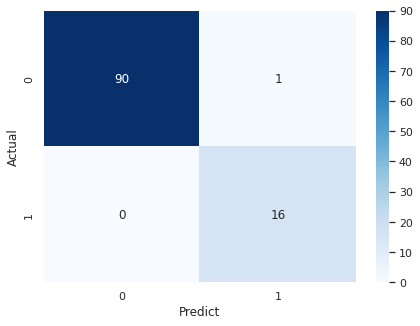

In [35]:
model.load_state_dict(torch.load(f'{config.model_name}.pt'))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs)

        y_true.append(config.classes[labels.item()])
        _, predicted = torch.max(logits, 1)
        y_pred.append(config.classes[predicted.item()])

print(classification_report(y_true, y_pred, digits=4))
plt.figure(figsize=(7, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()